#  Forecasting taxi orders

The company "An awesome taxi" collected historical data on taxi orders at airports. To attract more drivers during peak load, you need to predict the number of taxi orders for the next hour. Build a model for such a prediction.

The value of the *RMSE* metric in the test sample should be no more than 48.

You need to:

1. Download the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on the test sample and draw conclusions.


The data is in the file `taxi.csv'. The number of orders is in the `num_orders` column (from English *number of orders*, "number of orders").

## Preparation

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime as dt
import numpy as np
import seaborn as sns
from numpy.random import RandomState
from pylab import rcParams
# from sklearn.metrics import r2_score
# from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from datetime import datetime, time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error

from scipy.fft import fft, fftfreq

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm, notebook


from lightgbm import LGBMRegressor

from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from prophet import Prophet


In [60]:
rcParams['figure.figsize'] = (12, 8)

pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.max_columns = 100
pd.set_option('display.max_rows', 200)
pd.options.mode.chained_assignment = None

plt.rcParams['image.cmap'] = 'Set2'
plt.set_cmap("Set2");

sns.set_style("whitegrid", {'figure.facecolor': '0.97'});
sns.set_palette("Set2");

RANDOM_STATE = 2007

<Figure size 864x576 with 0 Axes>

In [61]:
# A function for studying the dataset, we will apply it to different dataframes
def evaluate_df(df, show_corr_zero_plots = False, show_corr_null_plots=False, show_scatter_matrix=False):
    print('\n------SAMPLE--------')
    display(df.sample(min(5,len(df))))
    print('\n------DTYPES--------')
    print(df.dtypes)

    # count of NaN
    print('\n\n------NaN & zero--------')
    na = pd.DataFrame(index=df.columns
                      , data={
                          'NA':df.isna().sum().values
                          , 'filled': df.notna().sum().values
                          , 'zero':df.isin([0,'0']).sum()
                      }
                     )
    na['%na'] = na['NA']/len(df)*100
    print(na.replace(0,'-'))
    

    display('Numeric columns', df.describe(include=[np.number]).transpose())
    

In [62]:
def RMSE(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def make_features(data, index_feautures, lags, rolling_mean_size):
    enhanced_data = data.copy()
    if 'Y' in index_feautures:
        enhanced_data['year'] = enhanced_data.index.year
    if 'M' in index_feautures:
        enhanced_data['month'] = enhanced_data.index.month
    if 'D' in index_feautures:
        enhanced_data['day'] = enhanced_data.index.day
    if 'H' in index_feautures:
        enhanced_data['hour'] = enhanced_data.index.hour
    if 'WD' in index_feautures:
        enhanced_data['dayofweek'] = enhanced_data.index.dayofweek
    if 'YW' in index_feautures:
        enhanced_data['weekofyear'] = enhanced_data.index.weekofyear
    
    if type(enhanced_data) == pd.Series:
        enhanced_data = enhanced_data.to_frame()

    data_column = enhanced_data[enhanced_data.columns[0]]
    
    for lag in lags:
        enhanced_data['lag_{}'.format(lag)] = data_column.shift(lag)

    enhanced_data['rolling_mean'] = data_column.shift().rolling(rolling_mean_size).mean()
    return enhanced_data

def plot_cum_rmse(t):
    cs = [np.nan]
    for i in range(1,len(t)):
        cs.append(RMSE(t.iloc[:i,0], t.iloc[:i,1]))
    t['rmse_cum'] = cs
    ax = t['rmse_cum'].plot(xlabel='points', ylabel='RMSE')
    ax.set_title('Change RMSE on adding points')
    
    print('RMSE:', RMSE(t[0], t[1]))
    print('MAE:', mean_absolute_error(t[0],t[1]))
    print('MeanError:', np.mean(t[0]-t[1]))
    plt.show()

In [63]:
# Series Stationarity test (ADF and KPSS)
def test_stationarity(ts):
    statistic, p_value, n_lags, nobs, critical_values, icbest = adfuller(ts, maxlag=None, regression='ct', autolag='AIC', store=False, regresults=False)

    print(f'ADF\n----------------------\nStatistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    if p_value <0.05:
        print('Result:\n\tH0 rejected (H0: The data is not stationary).\n\tH1 accepted: The data is stationary around a trend\n-----------------------\n')
    else:
        print('Result:\n\tH0 could not be rejected (H0: The data is not stationary).\n-----------------------\n')



    statistic, p_value, n_lags, critical_values = kpss(ts, regression='ct', nlags='legacy', store=False)
    print(f'KPSS\n----------------------\nStatistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    # print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary\n-----------------------\n')
    if p_value <0.05:
        print('Result:\n\tH0 rejected (H0: The data is stationary around a trend).\n\tH1 accepted: The data is not stationary\n-----------------------\n')
    else:
        print('Result:\n\tH0 could not be rejected (H0: The data is stationary around a trend).\n-----------------------\n')

# make FastFurierTransform & evaluate main periods
def fft_periods(sgnl):
    # series length
    N = len(sgnl)

    # period
    #(you can enter T=1.0/24.0, but it will be a little less convenient)
    T = 1.0

    # fast 1D Fourier transform
    yf = fft(sgnl)
    xf = fftfreq(N, T)[:N//2]

    # power factor
    power = 2.0/N *np.abs(yf[0:N//2])

    # Spectrum plot
    plt.plot(xf[1:], power[1:])
    # plt.grid()
    plt.show()

    # Let's assemble a frame with periods and power coefficients
    t = pd.DataFrame(data={
        'period': 1/xf[1:],
        'power': power[1:]
    })

    # np.set_printoptions(formatter={'float_kind':'{:f}'.format})

    # Select TOP n and build a histogram (barh)
    n=20
    tN = t[t['period']<N//2].sort_values(by='power').tail(n).sort_values(by='period')
    tN.plot.barh(y='power', x='period', ylabel='period', title=f'TOP{n} periods')
    plt.show()

# Plotting ACF and PACF
def tsplot(y, lags=None, figsize=(18, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

#         print("The Dickey-Fuller criterion: p=%f" % adfuller(y)[1])

        plt.tight_layout()
    return 

In [64]:
data = pd.read_csv('../../datasets/taxi.csv', sep=',', index_col=[0], parse_dates=[0])

In [65]:
# check for the monotony of the date index and sort if necessary
if ~data.index.is_monotonic:
    data.sort_index(inplace=True)
    
# resampling for 1 hour (24 points per day)
data = data.resample('1H').sum()
dataD = data.resample('1D').sum()

In [66]:
# Let's study the data
evaluate_df(data, False, False, False)


------SAMPLE--------


,num_orders
datetime,
2018-08-06 16:00:00,204
2018-08-20 16:00:00,172
2018-08-22 21:00:00,137
2018-08-09 21:00:00,144
2018-04-14 02:00:00,52



------DTYPES--------
num_orders    int64
dtype: object


------NaN & zero--------
           NA  filled  zero %na
num_orders  -    4416     1   -


'Числовые поля'

,count,mean,std,min,25%,50%,75%,max
num_orders,"4,416.000",84.423,45.024,0.000,54.000,78.000,107.000,462.000


There is one zero in the data. This will need to be taken into account when choosing a model

<AxesSubplot:xlabel='datetime'>

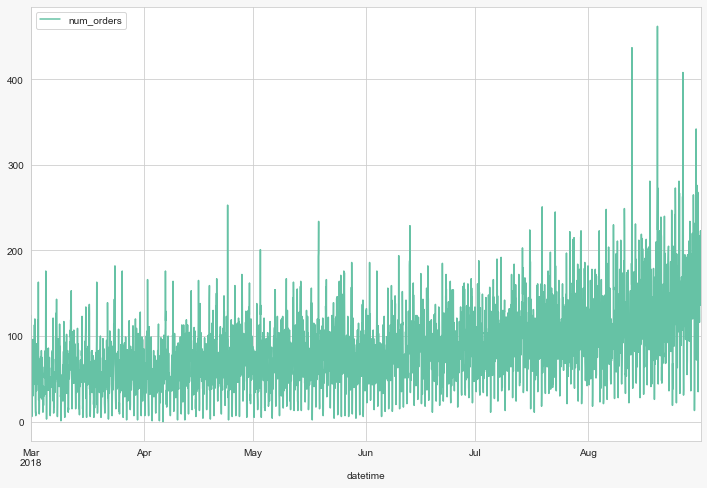

In [67]:
# plot a time series graph
data.plot()

Let's check that there are no gaps in the data (missed hours). To do this, let's calculate how many hours there should be between MAX and MIN hours and compare how many records we actually have.

In [68]:
data.index[-1]-data.index[0]

Timedelta('183 days 23:00:00')

In [69]:
# The number of hours in observations that should be
183*24+23+1

4416

In [70]:
# Actual number of hours
len(data)

4416